In [1]:
import pandas as pd
import numpy as np

from src.data_handling import (load_csv_data, 
                               filter_data_by_year_range, 
                               append_string_to_elements, 
                               save_to_csv)

from matplotlib import pyplot as plt

from src.vol_forecasting import GARCHVolForecast, StochasticVolForecast
from arch import arch_model

from src.visualisations import plot_forecast


In [2]:
DATA_PATH = "DATA/processed/df.csv"

df = load_csv_data(DATA_PATH)

MODELING_YEARS = (2015, 2025)

df = filter_data_by_year_range(df, *MODELING_YEARS)
df.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,...,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,IRX_Open,IRX_High,IRX_Low,IRX_Close,IRX_Adj Close,Year
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.531765,212818400.0,15.6290,15.7375,15.3480,15.4260,...,20.139999,17.049999,17.790001,17.790001,0.030,0.030,0.015,0.015,0.015,2015
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.840672,257142000.0,15.3505,15.4190,15.0425,15.1095,...,21.290001,19.190001,19.920000,19.920000,0.008,0.018,0.003,0.003,0.003,2015
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.842909,263188400.0,15.1120,15.1500,14.6190,14.7645,...,22.900000,19.520000,21.120001,21.120001,0.023,0.023,0.018,0.020,0.020,2015
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.177242,160423600.0,14.8750,15.0640,14.7665,14.9210,...,20.719999,19.040001,19.309999,19.309999,0.023,0.025,0.020,0.020,0.020,2015
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.106180,237458000.0,15.0160,15.1570,14.8055,15.0230,...,18.090000,16.990000,17.010000,17.010000,0.020,0.020,0.015,0.018,0.018,2015


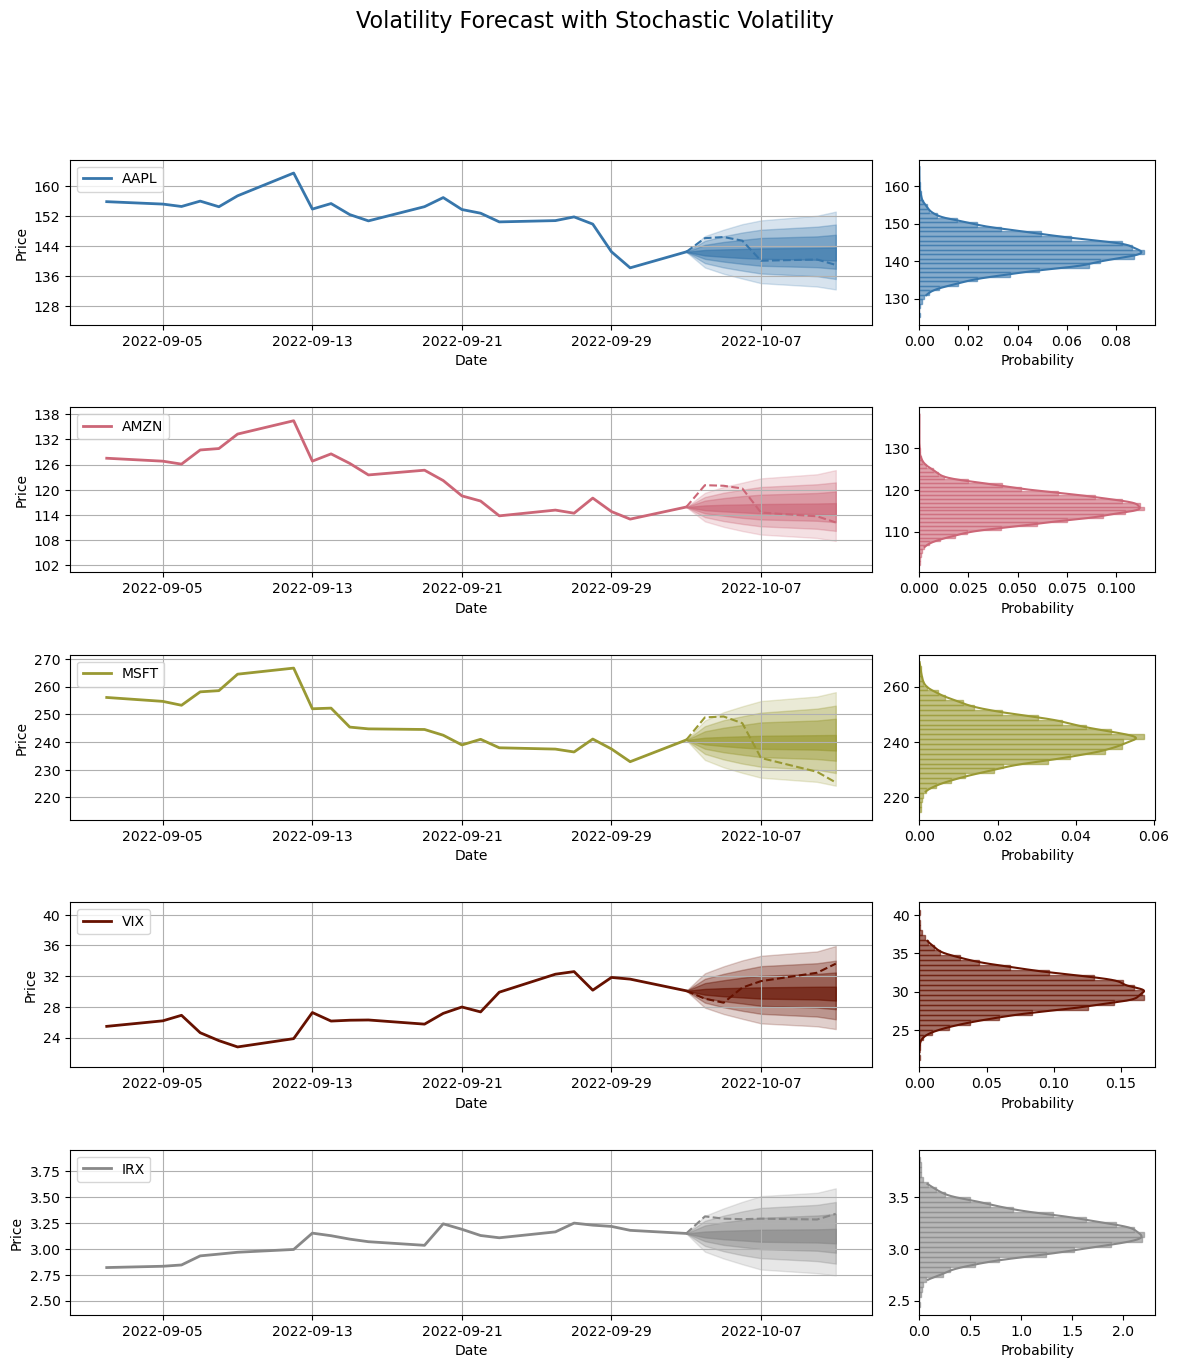

In [3]:
from src.stoch_modelling import CorrelatedJDMSimulator, JDMSimulator, CIRJumpModel

start = 2000
end = start+20
n_days = 7
# Simulating equities
# Initialising
corjdm_model = CorrelatedJDMSimulator()
# Estimating parameters
corjdm_model.estimate_parameters(df[['AAPL_Close', 'AMZN_Close', 'MSFT_Close']].iloc[start:end].values)
# Setting initial prices
corjdm_model.initial_prices = df[['AAPL_Close', 'AMZN_Close', 'MSFT_Close']].iloc[end+1].values
# Generating simulation 
corjdm_sim = np.array([corjdm_model.simulate(n_days) for _ in range(10_000)])


# Simulating VIX
# Initialising
jdm_model = JDMSimulator()
# Estimating parameters
vix_res = jdm_model.estimate_parameters(df['VIX_Close'].iloc[start:end].values)
# Setting initial prices
jdm_model.initial_price = df['VIX_Close'].iloc[end+1]
# Generating Simulation
jdm_sim = np.array([jdm_model.simulate(n_days-1) for _ in range(10_000)])

# Simulating IRX
# Initialising
cirj_model = CIRJumpModel()
# Estimating parameters
cirj_model.estimate_parameters(df['IRX_Close'].iloc[start:end].values)
# Setting initial prices
cirj_model.initial_rate = df['IRX_Close'].iloc[end+1]
# Generating Simulation
cirj_sim = np.array([cirj_model.simulate(n_days-1) for _ in range(10_000)])



data_list = [(df['AAPL_Close'].iloc[start:end+n_days+1], corjdm_sim[:, :, 0]),
             (df['AMZN_Close'].iloc[start:end+n_days+1], corjdm_sim[:, :, 1]),
             (df['MSFT_Close'].iloc[start:end+n_days+1], corjdm_sim[:, :, 2]),
             (df['VIX_Close'].iloc[start:end+n_days+1], jdm_sim),
             (df['IRX_Close'].iloc[start:end+n_days+1], cirj_sim)]

assets = ['AAPL', 'AMZN', 'MSFT', 'VIX', 'IRX']

colours = ['#3776AB', '#CC6677', '#999933', '#661100', '#888888']

stochastic_volatility_forecast_plot = plot_forecast(data_list, assets, colours)

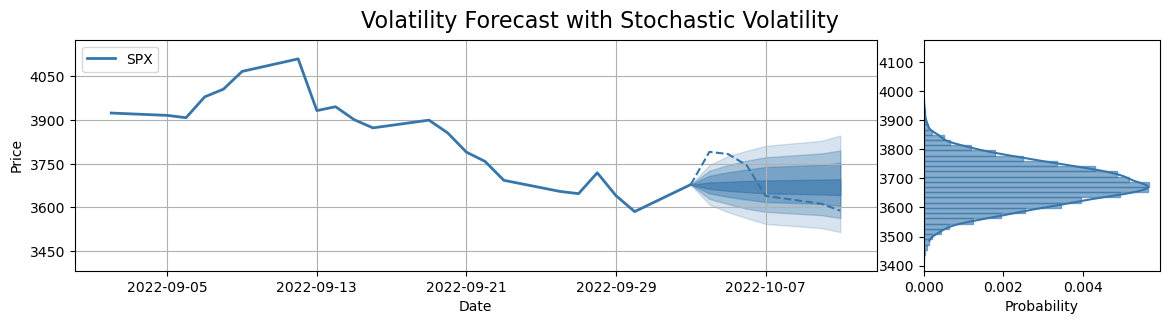

In [12]:
from src.linear_factor_model import LinearFactorModel

factors = ['AAPL_Close', 'AMZN_Close', 'MSFT_Close', 'VIX_Close', 'IRX_Close']
target  = 'SPX_Close'


spx_factors = df[factors].values

# Create an instance of the LinearFactorModel class
spx_lfm = LinearFactorModel()

# Train the model
spx_lfm.fit(df[target].values, spx_factors)

# Reshaping and concatenating monte carlo simulations
jdm_sim_expanded  = np.expand_dims(jdm_sim, axis=-1)
cirj_sim_expanded = np.expand_dims(cirj_sim, axis=-1)
stochastic_volatility_factors = np.concatenate([corjdm_sim, jdm_sim_expanded, cirj_sim_expanded], axis=2)

# Predicting volatility
spx_pred_vol_forecast = spx_lfm.predict(stochastic_volatility_factors)

# Scaling volatility from monte carlo simulations to actual SPX data
spx_actual_vol_forecast = ((spx_pred_vol_forecast.T / spx_pred_vol_forecast[:,0,]) * df['SPX_Close'].iloc[end+1]).T

# Plotting results
spx_lfm_plot = plot_forecast([(df['SPX_Close'].iloc[start:end+n_days+1], spx_actual_vol_forecast)], ['SPX'], colours)
